In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D, Flatten, MaxPooling1D, GRU, Dropout
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.preprocessing import sequence
from collections import Counter
from sklearn.model_selection import train_test_split



import pandas as pd
import numpy as np
import re
import tensorflow as tf

In [3]:
df = pd.read_csv('/content/drive/Shareddrives/CS2470/books_datasetv2.csv')
df.head()

,Unnamed: 0,ISBN,title,series,author,rating,genre,publish_company,format,number_of_pages,publish_month,publish_year,NYT_bestseller,top5,length_of_title,top_authors
0,0,9781419726552,"F*ck, That's Delicious: An Annotated Guide to ...",0,Action Bronson,4.17,food-and-drink,Harry N. Abrams,Hardcover,192,September,2017,1.0,0,57,0
1,1,9780982301821,10-Day Green Smoothie Cleanse: Lose Up to 15 P...,0,J.J. Smith,4.11,health,Adiva Publishing,Paperback,167,February,2014,1.0,0,63,0
2,2,9780316407076,15th Affair,1,James Patterson,4.09,mystery,Hachette,Hardcover,351,May,2016,1.0,1,11,1
3,3,9780718088804,42 Faith: The Rest of the Jackie Robinson Story,0,Ed Henry,4.16,biography,Harper Collins,Hardcover,368,April,2017,1.0,1,47,0
4,4,9780451495426,7 Lessons from Heaven: How Dying Taught Me to ...,0,Mary C. Neal,4.08,non-fiction,Convergent Books,Paperback,288,September,2017,1.0,0,68,0


In [4]:
# select variables
X = df[['title', 'rating', 'number_of_pages', 'publish_year', 'top_authors']]
y = df['NYT_bestseller']

#Preprocessing
## y

In [5]:
# Convert our labels into one-hot encoded vectors
label_encoder = preprocessing.LabelEncoder()


y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1001)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## X - text : title

In [6]:

# dataTEXT - title

def preprocess_text(sen):

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence
    
X1_train = []
sentences = list(X_train["title"])
for sen in sentences:
    X1_train.append(preprocess_text(sen))


X1_test = []
sentences = list(X_test["title"])
for sen in sentences:
    X1_test.append(preprocess_text(sen))


# tokenize
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X1_train)

X1_train = tokenizer.texts_to_sequences(X1_train)
X1_test = tokenizer.texts_to_sequences(X1_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X1_train = pad_sequences(X1_train, padding='post', maxlen=maxlen)
X1_test = pad_sequences(X1_test, padding='post', maxlen=maxlen)



In [7]:
# create word vectors
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/content/drive/Shareddrives/CS2470/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## X - numeric : rating, number of pages, publish year

In [8]:
X2_train = X_train[['rating', 'number_of_pages', 'publish_year']].values
X2_test = X_test[['rating', 'number_of_pages', 'publish_year']].values

X2_train = preprocessing.StandardScaler().fit_transform(X2_train)
X2_test = preprocessing.StandardScaler().fit_transform(X2_test)


 ## X - categorical : top_authors

In [9]:
X3_train = preprocessing.OneHotEncoder().fit_transform(np.asarray(X_train['top_authors']).reshape(-1,1)).toarray()
X3_test = preprocessing.OneHotEncoder().fit_transform(np.asarray(X_test['top_authors']).reshape(-1,1)).toarray()


In [10]:
X23_train = tf.concat([X2_train, X3_train], 1)
X23_test = tf.concat([X2_test, X3_test], 1)

# Create three input layers: X1 , X2, X3

In [11]:
input_1 = Input(shape=(maxlen,))
input_2 = Input(shape=(5,))

# Model - 1

In [40]:
# input 1 - text
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
GRU_Layer_1 = GRU(128)(embedding_layer)

# input 2 - numeric + binary
dense_layer_1 = Dense(10, activation='relu')(input_2)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)



# concat
concat_layer = Concatenate()([GRU_Layer_1, dense_layer_2])

dense_layer_3 = Dense(10, activation='relu')(concat_layer)
output = Dense(2, activation='softmax')(dense_layer_3)
model = Model(inputs=[input_1, input_2], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 200, 100)     236500      ['input_1[0][0]']                
                                                                                                  
 dense_40 (Dense)               (None, 10)           60          ['input_2[0][0]']                
                                                                                            

## plot model

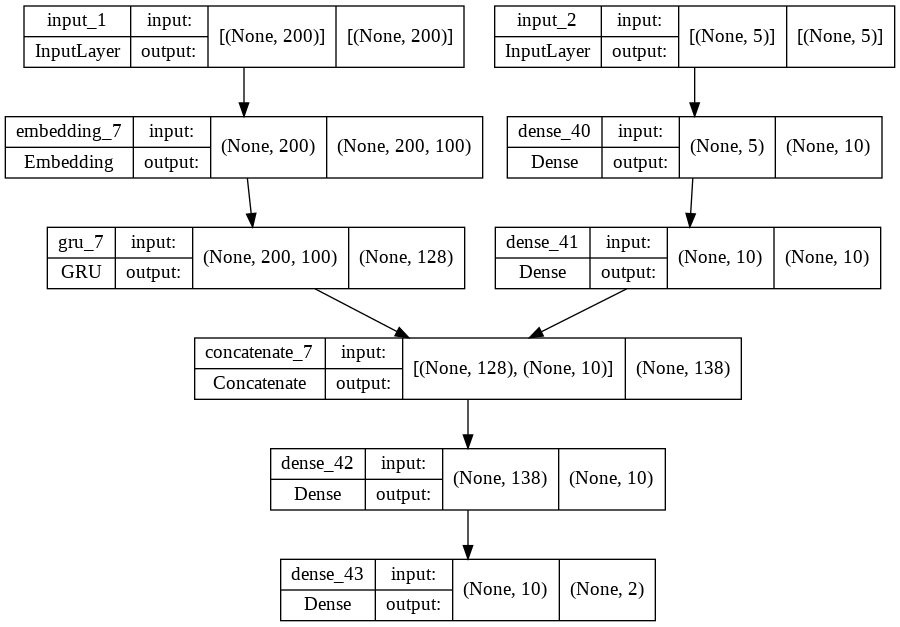

In [42]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_1.png', show_shapes=True, show_layer_names=True)


# training

In [35]:
train_fit = model.fit(x=[X1_train, X23_train], y = y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)


Epoch 1/10
9/9 [==============================] - 8s 596ms/step - loss: 0.6872 - acc: 0.6207 - val_loss: 0.6571 - val_acc: 0.6629
Epoch 2/10
9/9 [==============================] - 5s 519ms/step - loss: 0.6654 - acc: 0.6587 - val_loss: 0.6468 - val_acc: 0.6629
Epoch 3/10
9/9 [==============================] - 5s 520ms/step - loss: 0.6477 - acc: 0.6587 - val_loss: 0.6455 - val_acc: 0.6629
Epoch 4/10
9/9 [==============================] - 7s 869ms/step - loss: 0.6389 - acc: 0.6597 - val_loss: 0.6314 - val_acc: 0.6629
Epoch 5/10
9/9 [==============================] - 7s 816ms/step - loss: 0.6251 - acc: 0.6606 - val_loss: 0.6229 - val_acc: 0.6629
Epoch 6/10
9/9 [==============================] - 8s 848ms/step - loss: 0.6153 - acc: 0.6692 - val_loss: 0.6139 - val_acc: 0.6705
Epoch 7/10
9/9 [==============================] - 5s 500ms/step - loss: 0.6072 - acc: 0.6901 - val_loss: 0.6036 - val_acc: 0.6894
Epoch 8/10
9/9 [==============================] - 6s 675ms/step - loss: 0.5946 - acc: 0.69

In [15]:
test_score = model.evaluate(x=[X1_test, X23_test], y=y_test, verbose=1)

print("Test Score:", test_score[0])
print("Test Accuracy:", test_score[1])

11/11 [==============================] - 1s 44ms/step - loss: 0.5362 - acc: 0.7273
Test Score: 0.5362271666526794
Test Accuracy: 0.7272727489471436


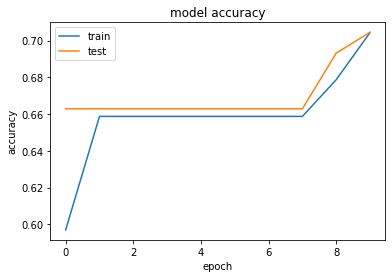

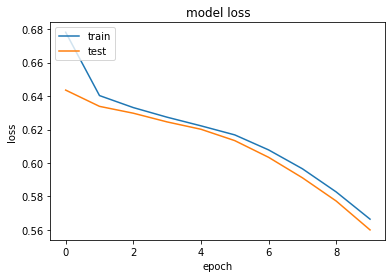

In [16]:
import matplotlib.pyplot as plt

plt.plot(train_fit.history['acc'])
plt.plot(train_fit.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(train_fit.history['loss'])
plt.plot(train_fit.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Model -2

In [23]:
# input 1 - text
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
x = Conv1D(filters=256, kernel_size=2, padding='same', activation='relu')(embedding_layer)
x = MaxPooling1D(pool_size=2, strides=1, padding='same')(x)
x = Conv1D(filters=128, kernel_size=2, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2, strides=1, padding='same')(x)
x = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2, strides=1, padding='same')(x)
x = GRU(128)(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
input_1_dense = Dense(32, activation='relu')(x)

# input 2 - numeric + binary
dense_layer_1 = Dense(256, activation='relu')(input_2)
dense_layer_2 = Dense(64, activation='relu')(dense_layer_1)
input_2_dense = Dense(32, activation='relu')(dense_layer_1)


# concat
concat_layer = Concatenate()([input_1_dense, input_2_dense])

dense_layer_3 = Dense(32, activation='relu')(concat_layer)
dense_layer_4 = Dense(32, activation='relu')(dense_layer_3)
output = Dense(2, activation='softmax')(dense_layer_4)
model = Model(inputs=[input_1, input_2], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 200, 100)     236500      ['input_1[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 200, 256)     51456       ['embedding_4[0][0]']            
                                                                                                  
 max_pooling1d_6 (MaxPooling1D)  (None, 200, 256)    0           ['conv1d_6[0][0]']               
                                                                                            

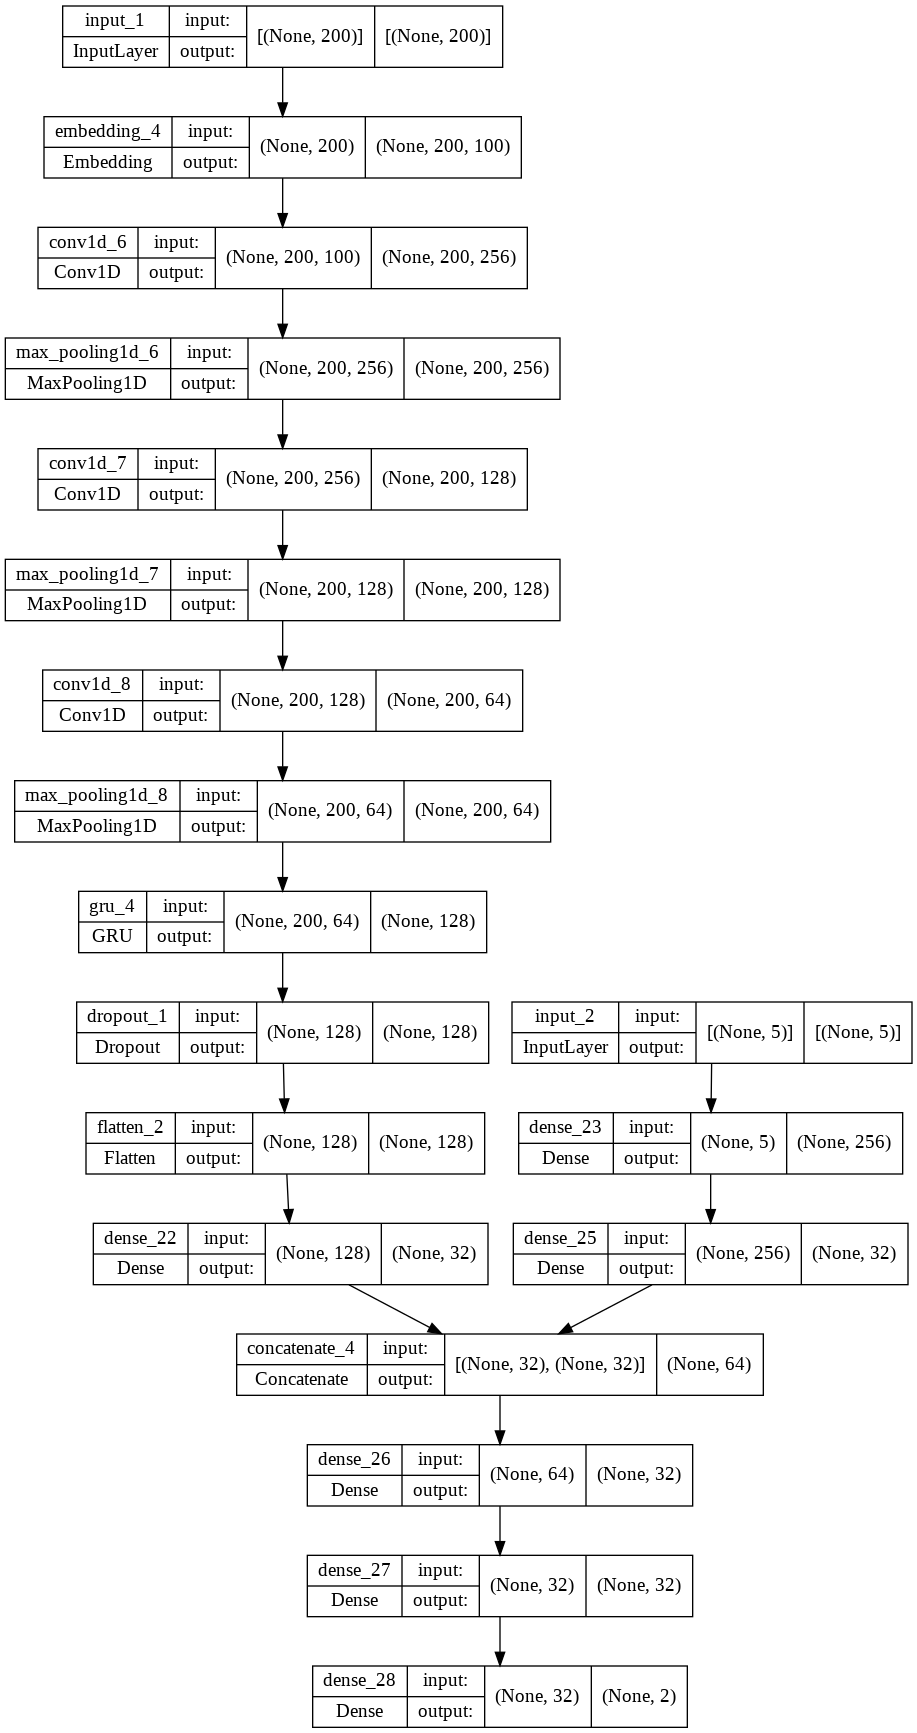

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [18]:
train_fit = model.fit(x=[X1_train, X23_train], y = y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)


Epoch 1/10
9/9 [==============================] - 21s 2s/step - loss: 0.6654 - acc: 0.6616 - val_loss: 0.6146 - val_acc: 0.7159
Epoch 2/10
9/9 [==============================] - 9s 1s/step - loss: 0.5762 - acc: 0.7234 - val_loss: 0.5343 - val_acc: 0.7311
Epoch 3/10
9/9 [==============================] - 9s 1s/step - loss: 0.4965 - acc: 0.7728 - val_loss: 0.4567 - val_acc: 0.7879
Epoch 4/10
9/9 [==============================] - 9s 1s/step - loss: 0.4268 - acc: 0.8023 - val_loss: 0.3981 - val_acc: 0.7879
Epoch 5/10
9/9 [==============================] - 9s 1s/step - loss: 0.3729 - acc: 0.8118 - val_loss: 0.3979 - val_acc: 0.7917
Epoch 6/10
9/9 [==============================] - 9s 1s/step - loss: 0.3648 - acc: 0.8013 - val_loss: 0.3762 - val_acc: 0.7955
Epoch 7/10
9/9 [==============================] - 9s 1s/step - loss: 0.3585 - acc: 0.8127 - val_loss: 0.3668 - val_acc: 0.7917
Epoch 8/10
9/9 [==============================] - 10s 1s/step - loss: 0.3495 - acc: 0.8146 - val_loss: 0.3693 

In [19]:
test_score = model.evaluate(x=[X1_test, X23_test], y=y_test, verbose=1)

print("Test Score:", test_score[0])
print("Test Accuracy:", test_score[1])

11/11 [==============================] - 1s 87ms/step - loss: 0.4605 - acc: 0.6576
Test Score: 0.46052390336990356
Test Accuracy: 0.657575786113739


# Model -3

In [36]:
# input 1 - text
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
x = Conv1D(filters=256, kernel_size=2, padding='same', activation='relu')(embedding_layer)
x = MaxPooling1D(pool_size=2, strides=1, padding='same')(x)
x = Conv1D(filters=128, kernel_size=4, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2, strides=1, padding='same')(x)
x = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2, strides=1, padding='same')(x)
x = GRU(256)(x)
x = Flatten()(x)
input_1_dense = Dense(32, activation='relu', use_bias = True)(x)

# input 2 - numeric + binary
dense_layer_1 = Dense(128, activation='relu', use_bias = True)(input_2)
dense_layer_2 = Dense(64, activation='relu', use_bias = True)(dense_layer_1)
input_2_dense = Dense(32, activation='relu')(dense_layer_1)


# concat
concat_layer = Concatenate()([input_1_dense, input_2_dense])

dense_layer_3 = Dense(64, activation='relu', use_bias = True)(concat_layer)
dense_layer_4 = Dense(32, activation='relu')(dense_layer_3)
output = Dense(2, activation='softmax')(dense_layer_4)
model = Model(inputs=[input_1, input_2], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 200, 100)     236500      ['input_1[0][0]']                
                                                                                                  
 conv1d_9 (Conv1D)              (None, 200, 256)     51456       ['embedding_6[0][0]']            
                                                                                                  
 max_pooling1d_9 (MaxPooling1D)  (None, 200, 256)    0           ['conv1d_9[0][0]']               
                                                                                            

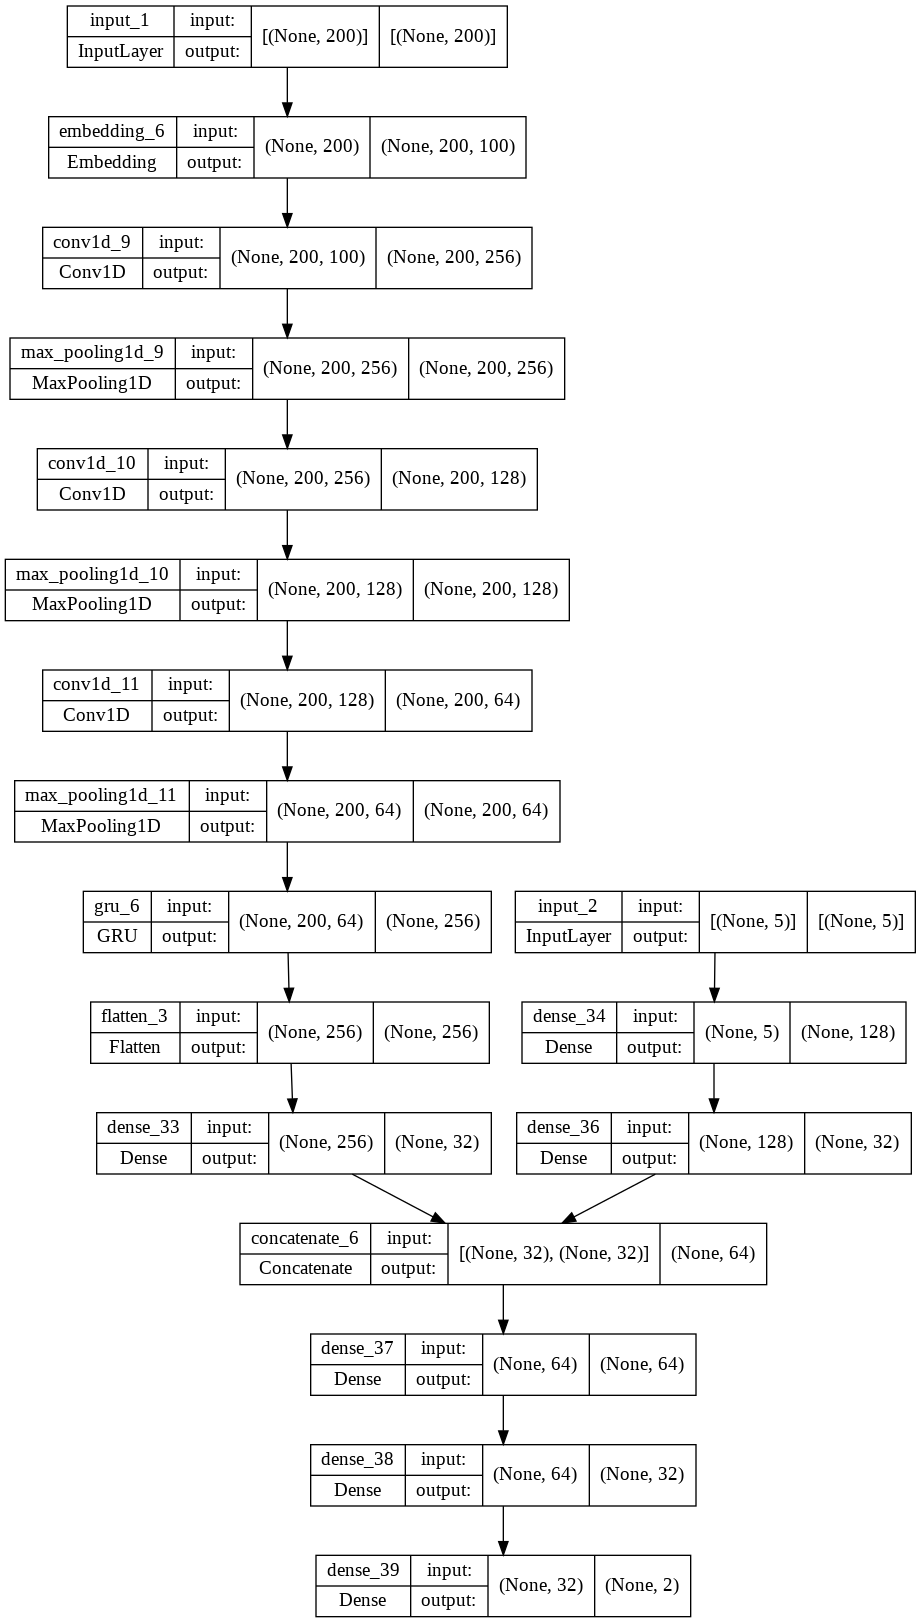

In [37]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [38]:
train_fit = model.fit(x=[X1_train, X23_train], y = y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)


Epoch 1/10
9/9 [==============================] - 20s 2s/step - loss: 0.6645 - acc: 0.6587 - val_loss: 0.6310 - val_acc: 0.6629
Epoch 2/10
9/9 [==============================] - 17s 2s/step - loss: 0.6081 - acc: 0.6587 - val_loss: 0.5794 - val_acc: 0.6629
Epoch 3/10
9/9 [==============================] - 18s 2s/step - loss: 0.5609 - acc: 0.6730 - val_loss: 0.5329 - val_acc: 0.7159
Epoch 4/10
9/9 [==============================] - 18s 2s/step - loss: 0.5112 - acc: 0.7614 - val_loss: 0.4860 - val_acc: 0.7803
Epoch 5/10
9/9 [==============================] - 17s 2s/step - loss: 0.4649 - acc: 0.7994 - val_loss: 0.4337 - val_acc: 0.7955
Epoch 6/10
9/9 [==============================] - 17s 2s/step - loss: 0.4082 - acc: 0.8070 - val_loss: 0.3862 - val_acc: 0.7955
Epoch 7/10
9/9 [==============================] - 17s 2s/step - loss: 0.3713 - acc: 0.8118 - val_loss: 0.3719 - val_acc: 0.7765
Epoch 8/10
9/9 [==============================] - 17s 2s/step - loss: 0.3939 - acc: 0.7643 - val_loss: 0

In [39]:
test_score = model.evaluate(x=[X1_test, X23_test], y=y_test, verbose=1)

print("Test Score:", test_score[0])
print("Test Accuracy:", test_score[1])

11/11 [==============================] - 2s 178ms/step - loss: 0.3696 - acc: 0.8121
Test Score: 0.369573175907135
Test Accuracy: 0.8121212124824524
